## Adaptive Approximate Bayesian Computation Tolerance Selection

To use ABC-SMC one has to choose the tolerance threshold or acceptance quantiles beforehand to run the method. However, Simola et al. [1] describe an adaptive strategy for selecting the threshold based on density ratios of rejection ABC posteriors. This tutorial teaches you how to use the adaptive threshold selection method.

In [1]:
import numpy as np
# from scipy.stats import norm
import scipy.stats as ss
import elfi
import logging
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

%matplotlib inline

# Set an arbitrary global seed to keep the randomly generated quantities the same
seed = 10
np.random.seed(seed)



We reproduce the Example 1 from [1] as a test case for `AdaptiveThresholdSMC`.

In [2]:
def gaussian_mixture(theta, batch_size=1, random_state=None):
    sigma1 = 1
    sigma2 = np.sqrt(0.01)
    sigmas = np.array((sigma1, sigma2))
    mixture_prob = 0.5
    random_state = random_state or np.random
    
    scale_array = random_state.choice(sigmas,
                                      size=batch_size,
                                      replace=True,
                                      p=np.array((mixture_prob, 1-mixture_prob)))
    observation = ss.norm.rvs(loc=theta,
                              scale=scale_array,
                              size=batch_size,
                              random_state=random_state)
    
    return observation
    

In [3]:
yobs = 0
model = elfi.ElfiModel()
elfi.Prior('uniform', -10, 20, name='theta', model=model)
elfi.Simulator(gaussian_mixture, model['theta'], observed=yobs, name='GM')
elfi.Distance('euclidean', model['GM'], name='d');

In [4]:
smc = elfi.SMC(model['d'], batch_size=500, seed=1)
thresholds = [1., 0.5013, 0.2519, 0.1272, 0.0648, 0.0337, 0.0181, 0.0102, 0.0064, 0.0025]
smc_samples = smc.sample(1000, thresholds=thresholds)

ABC-SMC Round 1 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 3 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 4 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 5 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 6 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 7 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 8 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 9 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 10 / 10
Progress [==================================================] 100.0% Complete


Adaptive threshold selection ABC (`elfi.AdaptiveThresholdSMC`) can be used in similar fashion as `elfi.SMC`. One does not need to provide a list of thresholds but user can set densityratio-based termination condition (`q_threshold`) and a limit for the number of iterations (`max_iter`). 

In [5]:
adaptive_smc = elfi.AdaptiveThresholdSMC(model['d'], batch_size=500, seed=2, q_threshold=0.995)
adaptive_smc_samples = adaptive_smc.sample(1000, max_iter=10)

ABC-SMC Round 1 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 3 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 4 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 5 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 6 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 7 / 10
Progress [==================================================] 100.0% Complete
ABC-SMC Round 8 / 10
Progress [==================================================] 100.0% Complete


We compare visually the approximated posterior and the true posterior, which in this case is available. 

In [6]:
def gaussian_mixture_density(theta, sigma_1=1, sigma_2=0.1):
    y = 0.5 * ss.norm.pdf(theta, loc=0, scale=sigma_1) + 0.5 * ss.norm.pdf(theta, loc=0, scale=sigma_2)
    return y

In [7]:
print(smc_samples)
print(adaptive_smc_samples)

Method: SMC
Number of samples: 1000
Number of simulations: 1352000
Threshold: 0.0025
Sample means: theta: 0.0181

Method: AdaptiveThresholdSMC
Number of samples: 1000
Number of simulations: 49500
Threshold: 0.236
Sample means: theta: -0.042



We compute Kernel density estimates of the posteriors based on the approximate posterior samples and visualise them in a density plot. 

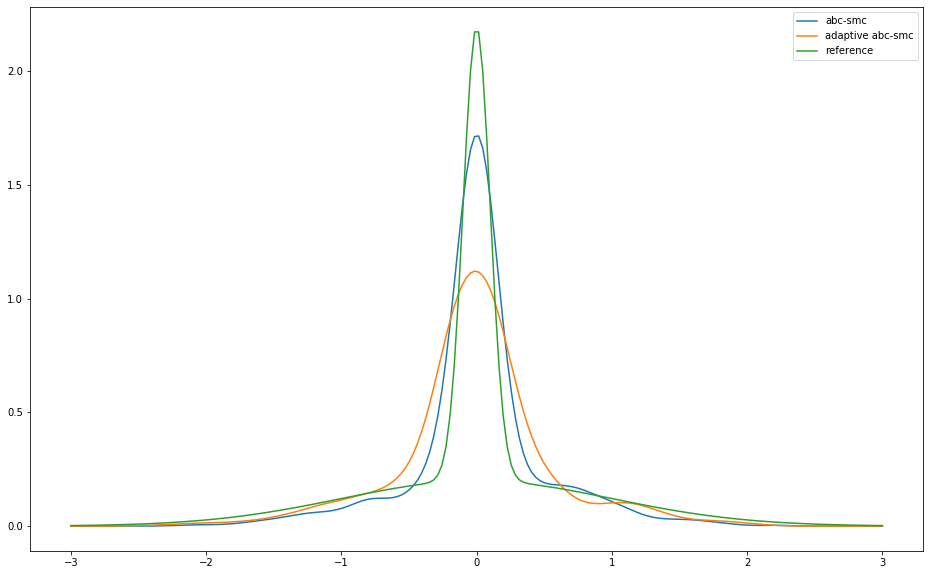

In [8]:
smc_posteriorpdf = gaussian_kde(smc_samples.samples_array[:,0])
adaptive_smc_posteriorpdf = gaussian_kde(adaptive_smc_samples.samples_array[:,0])

reference_posteriorpdf = gaussian_mixture_density

xs = np.linspace(-3,3,200)
smc_posteriorpdf.covariance_factor = lambda : .25
smc_posteriorpdf._compute_covariance()
adaptive_smc_posteriorpdf.covariance_factor = lambda : .25
adaptive_smc_posteriorpdf._compute_covariance()
plt.figure(figsize=(16,10))
plt.plot(xs,smc_posteriorpdf(xs))
plt.plot(xs,adaptive_smc_posteriorpdf(xs))
plt.plot(xs,reference_posteriorpdf(xs))
plt.legend(('abc-smc', 'adaptive abc-smc', 'reference'));

[1] Simola, U., Cisewski-Kehe, J., Gutmann, M.U. and Corander, J. [*Adaptive Approximate Bayesian Computation Tolerance Selection*](https://projecteuclid.org/journals/bayesian-analysis/advance-publication/Adaptive-Approximate-Bayesian-Computation-Tolerance-Selection/10.1214/20-BA1211.full), Bayesian Analysis 1(1):1-27, 2021
